## Setup

In [5]:
import os
from pathlib import Path
import random

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

main dir: /Users/pablo/github/aesuelogit


In [3]:
# Internal modules
from src.aesuelogit.models import UtilityParameters, BPRParameters, ODParameters, GISUELOGIT, NGD
from src.aesuelogit.networks import load_k_shortest_paths, build_tntp_network, Equilibrator, ColumnGenerator
from src.aesuelogit.etl import get_design_tensor, get_y_tensor, simulate_suelogit_data
from src.aesuelogit.experiments import *

In [4]:
# Seed for reproducibility
_SEED = 2022

np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

## Experiments

In [5]:
list_experiments = ['convergence', 'multiday', 'noisy_counts', 'noisy_od', 'ill_scaled_od']

In [6]:
run_experiment = dict.fromkeys(list_experiments,True)
# run_experiment = dict.fromkeys(list_experiments, False)

# run_experiment['convergence'] = True
run_experiment['multiday'] = True
# run_experiment['noisy_counts'] = True
# run_experiment['noisy_od'] = True
# run_experiment['ill_scaled_od'] = True

## Build network

In [7]:
network_name = 'SiouxFalls'

tntp_network = build_tntp_network(network_name=network_name)

## Read OD matrix

In [8]:
Q = isl.reader.read_tntp_od(network_name=network_name)
tntp_network.load_OD(Q=Q)

Reading Q from external file
Matrix Q (24, 24) read in 0.7[s]                        

360600.0 trips were loaded among 528 o-d pairs


## Load paths

In [9]:
load_k_shortest_paths(network=tntp_network, k=2, update_incidence_matrices=True)

Generating at most 2 paths per od
1056 paths were generated among 528 od pairs in 0.8 [s]

1056 paths were loaded in the network
Matrix D (76, 1056) generated in 1.0[s]               

Matrix M (528, 1056) generated in 0.8[s]               

Matrix C (1056, 1056) generated in 0.0[s]               



## Read synthetic traffic data

In [10]:
df = pd.read_csv(
    main_dir + '/output/network-data/' + tntp_network.key + '/links/' + tntp_network.key + '-link-data.csv')

n_days = len(df.period.unique())
n_links = len(tntp_network.links)
n_hours = 1

features_Z = ['c', 's']

## Data processing

In [11]:
traveltime_data = get_design_tensor(y=df['traveltime'], n_links=n_links, n_days=n_days, n_hours=n_hours)
flow_data = get_y_tensor(y=df[['counts']], n_links=n_links, n_days=n_days, n_hours=n_hours)

Y = tf.concat([traveltime_data, flow_data], axis=3)
X = get_design_tensor(Z=df[['traveltime'] + features_Z], n_links=n_links, n_days=n_days, n_hours=n_hours)

2022-05-31 12:49:01.666189: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Network equilibrium predictions

In [12]:
equilibrator = Equilibrator(
    network=tntp_network,
    max_iters=100,
    method='fw',
    iters_fw=50,
    accuracy=1e-4,
)

## Learning parameters

In [13]:
_EPOCHS = 20
_BATCH_SIZE = 4
_LR = 5e-1  # Default is 1e-3. With 1e-1, training becomes unstable

## Utility Function

In [14]:
utility_parameters = UtilityParameters(features_Y=['tt'],
                                       features_Z=features_Z,
                                       true_values={'tt': -1, 'c': -6, 's': -3, 'psc_factor': 0, 'fixed_effect': 0},
                                       initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                       'fixed_effect': np.zeros_like(tntp_network.links)},
                                       trainables={'psc_factor': False, 'fixed_effect': False},
                                       # trainables = None, #['features','psc_factor, fixed_effect']
                                       )

## Convergence Experiment


Epoch: 0, n_train: 102, n_test: 26

SUE via fw (max iters: 100)

Equilibrium gaps: ['0E+00']
Initial Fisk Objective: -52,510.66
Final Fisk Objective: -52,510.62
Improvement Fisk Objective: 0.00%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 0.3 [s]



SUE via fw (max iters: 100)

Equilibrium gaps: ['0E+00']
Initial Fisk Objective: -52,324.36
Final Fisk Objective: -52,324.29
Improvement Fisk Objective: 0.00%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 0.3 [s]


0: train_loss=1.4e+08,  val_loss=1.4e+08, train_loss tt=1.3e+02, val_loss tt=1.3e+02, train_loss flow=1.4e+08, val_loss flow=1.4e+08, train_loss bpr=1e+02, val_loss bpr=1e+02, theta = [-5.747  -2.7351 -4.4711], vot = 2.10, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 1, avg abs diff demand =6.8e+02, time:  1.0
train generalization error =1.1, 
val generalization error =1.1, 

Epoch: 1, n_train: 102, n_test: 26

SUE via fw (max iters: 100)

Equilibrium gaps: ['0E+00']
Initial Fisk Objective: 34,159,9


Equilibrium gaps: ['3E-05']
Initial Fisk Objective: -268,514,960.95
Final Fisk Objective: -268,092,796.85
Improvement Fisk Objective: 0.16%
Final gap: 3E-05. Acc. bound: 1E-04. Time: 0.5 [s]


9: train_loss=3.1e+05,  val_loss=2.4e+05, train_loss tt=3.7, val_loss tt=3.2, train_loss flow=3.1e+05, val_loss flow=2.4e+05, train_loss bpr=2.9, val_loss bpr=2.7, theta = [ -3.9217 -24.0928 -13.0003], vot = 0.16, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.2, avg beta = 3.5, avg abs diff demand =4.2e+02, time:  4.5
train generalization error =0.077, 
val generalization error =0.055, 

Epoch: 10, n_train: 102, n_test: 26

SUE via fw (max iters: 100)

Equilibrium gaps: ['2E-03', '4E-04', '6E-05']
Initial Fisk Objective: -265,818,648.46
Final Fisk Objective: -264,476,603.45
Improvement Fisk Objective: 0.50%
Final gap: 6E-05. Acc. bound: 1E-04. Time: 1.0 [s]



SUE via fw (max iters: 100)

Equilibrium gaps: ['5E-04', '8E-05']
Initial Fisk Objective: -265,063,067.96
Final Fisk Ob


Epoch: 19, n_train: 102, n_test: 26

SUE via fw (max iters: 100)

Equilibrium gaps: ['1E-06']
Initial Fisk Objective: -265,418,935.38
Final Fisk Objective: -265,412,839.79
Improvement Fisk Objective: 0.00%
Final gap: 1E-06. Acc. bound: 1E-04. Time: 0.6 [s]



SUE via fw (max iters: 100)

Equilibrium gaps: ['4E-06']
Initial Fisk Objective: -267,329,558.05
Final Fisk Objective: -266,725,260.52
Improvement Fisk Objective: 0.23%
Final gap: 4E-06. Acc. bound: 1E-04. Time: 0.5 [s]


19: train_loss=2e+05,  val_loss=1.6e+05, train_loss tt=2.6, val_loss tt=2.4, train_loss flow=2e+05, val_loss flow=1.6e+05, train_loss bpr=2.7, val_loss bpr=2.5, theta = [ -4.2612 -23.783  -14.0254], vot = 0.18, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.17, avg beta = 3.8, avg abs diff demand =4.4e+02, time:  3.9
train generalization error =0.042, 
val generalization error =0.049, 

Epoch: 20, n_train: 102, n_test: 26

SUE via fw (max iters: 100)

Equilibrium gaps: ['0E+00']
Initial Fisk Obj

/Users/pablo/OneDrive/data-science/github/aesuelogit/src/aesuelogit/visualizations.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


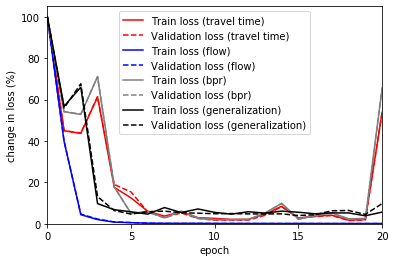

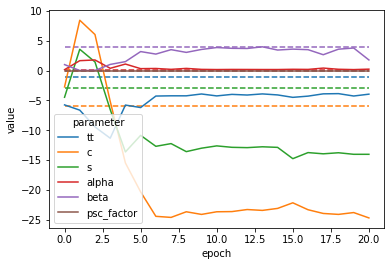

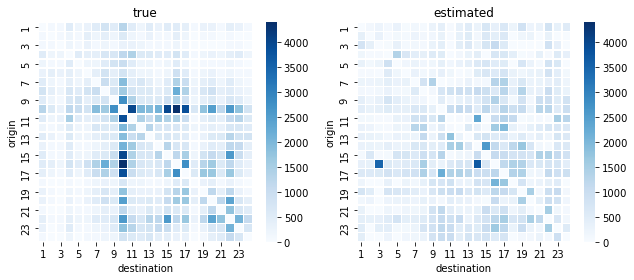

In [18]:
if run_experiment['convergence']:

    # optimizer = NGD(learning_rate=_LR)
    # optimizer = tf.keras.optimizers.Adagrad(learning_rate=_LR)
    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 1},
                                   # initial_values={'alpha': 0.05, 'beta': 2},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   trainables={'alpha': True, 'beta': True},
                                   # link_specifics = dict.fromkeys(['alpha','beta'],True)
                                   # trainables = ['alpha'],
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 initial_values = np.ones_like(tntp_network.q).flatten(),
                                 # initial_values=0.6 * tntp_network.q.flatten(),
                                 # initial_values=tntp_network.q.flatten(),
                                 true_values=tntp_network.q.flatten(),
                                 historic_values={1: tntp_network.q.flatten()},
                                 trainable=True)

    model = GISUELOGIT(
        key='model',
        network=tntp_network,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    convergence_experiment = ConvergenceExperiment(
        seed=_SEED,
        name='Convergence Experiment',
        folderpath=isl.config.dirs['output_folder'] + 'experiments/' + network_name,
        model=model,
        optimizer=optimizer,
        X=X,
        Y=Y)

    convergence_experiment.run(epochs=_EPOCHS,
                               test_size = 0.2,
                               batch_size=_BATCH_SIZE,
                               loss_weights={'od': 0, 'theta': 0, 'tt': 1, 'flow': 1, 'bpr': 0},)

## Multiday experiment


Multiday Experiment

Replicate 1


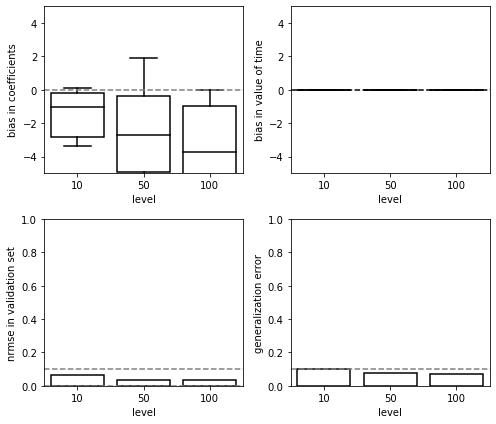


Replicate 2


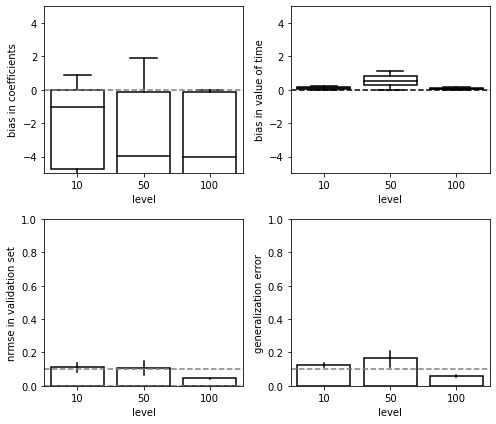


Replicate 3


In [ ]:
if run_experiment['multiday']:

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.1, 'beta': 1},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], True),
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 # initial_values=100*np.ones_like(tntp_network.q).flatten(),
                                 initial_values=0.5*tntp_network.q.flatten(),
                                 # initial_values=tntp_network.q.flatten(),
                                 true_values=tntp_network.q.flatten(),
                                 historic_values={1: tntp_network.q.flatten()},
                                 trainable=True)

    model = GISUELOGIT(
        key='model',
        network=tntp_network,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    multiday_experiment = MultidayExperiment(
        seed=_SEED,
        name='Multiday Experiment',
        folderpath=isl.config.dirs['output_folder'] + 'experiments/' + network_name,
        model=model,
        optimizer=optimizer,
        noise = {'tt': 0, 'flow': 0.1},
        X=X,
        Y=Y)

    multiday_experiment.run(epochs=_EPOCHS,
                            replicates = 50,
                            replicate_report = False,
                            show_replicate_plot = True,
                            range_initial_values= (-5,5),
                            batch_size=_BATCH_SIZE,
                            levels = [10,50,100],
                            loss_weights={'od': 0, 'theta': 0, 'tt': 1, 'flow': 1, 'bpr': 0},
                            )